---
# Exploratory Data Analysis
The data contains the following columns:
* **textID**: The ID assigned to the corresponding tweet
* **text**: The text of the tweet
* **selected_text**: Unique to the training set words/phrases that were used to define sentiment
* **sentiment**: The label (positive, negative, neutral)

The goal of the project is to predict the defining word(s) or phrase that exemplifies the provided sentiment

The end format should be as follows:

**id, "word(s)/phrase that drives sentiment"**

---
## Importing libraries

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from statistics import *
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
import json
from copy import deepcopy

from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop=set(stopwords.words('english'))
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ttsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing the Data

In [2]:
os.chdir('../')
train_data = pd.read_csv('data/raw/train.csv')
test_data = pd.read_csv('data/raw/test.csv')

In [3]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


---
### Data Description

In [5]:
train_data.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,12cfc10225,Strawberry margaritas + baked stuffed shrimp =,good,neutral
freq,1,1,199,11118


In [6]:
test_data.describe()

,textID,text,sentiment
count,3534,3534,3534
unique,3534,3534,3
top,861f5b2008,"waiting for aaron to get into town, and then l...",neutral
freq,1,1,1430


---
### Data Info

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


---
## Data Exploration

Exploring the length of reviews to see if there is any relationship between the length of reviews to the sentiment.

In [9]:
# Defining 'text' column in training and test as type string
train_data['text'] = train_data['text'].astype(str)
train_data['selected_text'] = train_data['selected_text'].astype(str)
test_data['text'] = test_data['text'].astype(str)

In [10]:
# Creating text_length variable for length of texts in train data
train_data['text_length'] = train_data['text'].apply(len)

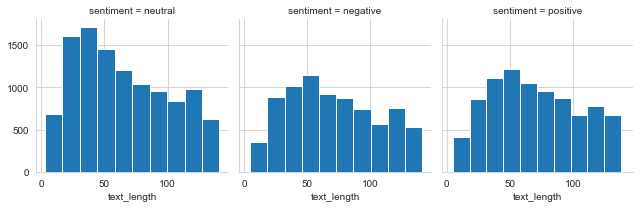

In [11]:
# Plotting the text lengths based on sentiment
sns.set_style('whitegrid')
train_graph = sns.FacetGrid(data=train_data, col='sentiment')
train_graph.map(plt.hist, 'text_length')

Viewing the frequency of the various sentiments in the training data

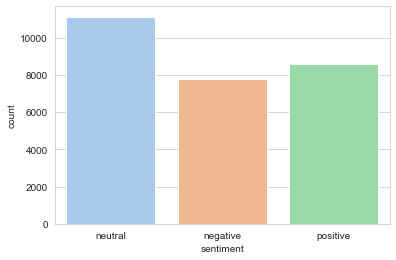

In [12]:
# Plotting the amount of tweets based on sentiment in the training data
sns.countplot(data=train_data, x='sentiment', palette='pastel')

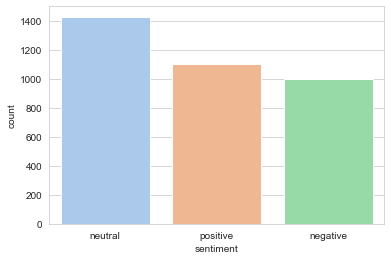

In [13]:
# Plotting the amount of tweets based on sentiment in the test data
sns.countplot(data=test_data, x='sentiment', palette='pastel')

## Further Data Exploration

Copying kernels to learn from and explore

### Cleaning the Data Further

In [14]:
def remove_stopwords(text):
    if text is not None:
        tokens = [x for x in word_tokenize(text) if x not in stop]
        return ' '.join(tokens)
    else:
        return None

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile('['
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                               ']+', flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in text if ch not in exclude)
    return s

def clean_data(df, train=True):
    df['dirty_text'] = df['text']
    df['text'] = df['text'].apply(lambda x : x.lower())
    df['text'] = df['text'].apply(lambda x : remove_emoji(x))
    df['text'] = df['text'].apply(lambda x : remove_URL(x))
    df['text'] = df['text'].apply(lambda x : remove_html(x))
    df['text'] = df['text'].apply(lambda x : remove_stopwords(x))
    df['text'] = df['text'].apply(lambda x : remove_punct(x))
    df.text = df.text.replace('/s+', ' ', regex=True)
    if train:
        df['selected_text'] = df['selected_text'].apply(lambda x : x.lower())
        df["selected_text"] = df['selected_text'].apply(lambda x : remove_emoji(x))
        df["selected_text"] = df['selected_text'].apply(lambda x : remove_URL(x))
        df["selected_text"] = df['selected_text'].apply(lambda x : remove_html(x))
        df["selected_text"] = df['selected_text'].apply(lambda x : remove_stopwords(x))
        df["selected_text"] = df['selected_text'].apply(lambda x : remove_punct(x))
        df.selected_text = df.selected_text.replace('/s+', ' ', regex=True)
    return df

train_df = clean_data(train_data)
test_df = clean_data(test_data, train=False)

In [20]:
def plot_distrib_train_test(train, test):
    fig = make_subplots(1, 2, subplot_titles=('Training set', 'Test set'))
    x = train.sentiment.value_counts()
    fig.add_trace(go.Bar(x=x.index, y=x.values, marker_color=['orange', 'green', 'red'], name=''), row=1, col=1)
    x = test.sentiment.value_counts()
    fig.add_trace(go.Bar(x=x.index, y=x.values, marker_color=['orange', 'green', 'red'], name=''), row=1, col=2)
    fig.show()
    
def show_word_distrib(df, target='positive', field='text', top_N=10, selected=True):
    fig = plt.figure()
    txt = df[df['sentiment']==target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    word_except_stop_dist = nltk.FreqDist(words)
    rslt = pd.DataFrame(words_except_stop.most_common(top_N),
                       columns = ['Word', 'Frequency Text']).set_index('Word')
    print(rslt)
    matplotlib.style.use('ggplot')
    ax1 = fig.add_subplot()
    rslt.plot.bar(rot=0, ax=ax1)
    
    if selected:
        txt = df[df['sentiment']==target]['selected_text'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
        words = nltk.tokenize.word_tokenize(txt)
        words_except_stop_dist = nltk.FreqDist(words)
        rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                           columns = ['Word', 'Frequency Selected Text']).set_index('Word')
        print(rslt)
        matplotlib.style.use('ggplot')
        ax2 = fig.add_subplot()
        rslt.plot.bar(rot=0, ax=ax2)
        plt.show()
        
def general_stats(train, test):
    n_train = len(train)
    n_test = len(test)
    
    print('Number of train samples: {}'.format(n_train))
    print('Number of test samples: {}'.format(n_test))
    plot_distrib_train_test(train, test)
    
    print('Word distribution of text and selected_text in Training set for positive samples')
    show_word_distrib(train, target='positive')
    
    print('Word distribution of text and selected_text in Training set for neutral samples')
    show_word_distrib(train, target='neutral')
    
    print('Word distribution of text and selected_text in Training set for negative samples')
    show_word_distrib(train, target='negative')
        
    print('Word distribution of text in Test set for positive samples')
    show_word_distrib(test, target='positive', selected=False)
    
    print('Word distribution of text in Test set for neutral samples')
    show_word_distrib(test, target='neutral', selected=False)
    
    print('Word distribution of text in Test set for negative samples')
    show_word_distrib(test, target='negative', selected=False)
    
def plot_hist_classes(df, to_plot, header, col='text'):
    fig, (ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(10, 5))
    
    df_len = to_plot(df, 'negative', col=col)
    ax1.hist(df_len, color='red')
    ax1.set_title('Negative Tweets')
    
    df_len = to_plot(df, 'positive', col=col)
    ax2.hist(df_len, color='green')
    ax2.set_title('Positive Tweets')
    
    df_len = to_plot(df, 'neutral', col=col)
    ax3.hist(df_len, color='orange')
    ax3.set_title('Neutral Tweets')
    
    fig.suptitle(_header)
    plt.show()
    plt.close()
    
def average_word_length(df, col='text'):
    fig,(ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(10, 5))
    
    word=df[df['sentiment']=='negative'][col].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x : np.mean(x)), ax=ax1, color='red')
    ax1.set_title('Negative')
    
    word=df[df['sentiment']=='positive'][col].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x : np.mean(x)), ax=ax2, color='green')
    ax2.set_title('Positive')
    
    word=df[df['sentiment']=='neutral'][col].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x : np.mean(x)), ax=ax3, color='orange')
    ax3.set_title('Neutral')
    
    fig.suptitle('Average word length in each tweet')
    plt.show()
    
def unique_words(df, col='text', title='Distribution of number of unique words'):
    fig, ax=plt.subplots(1, 3, figsize=(12, 7))
    colors = {
        'positive' : 'green',
        'negative' : 'red',
        'neutral' : 'orange'
    }
    for _, i in enumerate(['positive', 'negative', 'neutral']):
        new=df[df['sentiment']==i][col].map(lambda x : len(set(x.split())))
        sns.distplot(new.values, ax=ax[_], color=colors[i])
        ax[_].set_title(i)
    fig.suptitle(title)
    fig.show()
        
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stop).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x : x[1], reverse=True)
    return words_freq[:20]

def plot_n_grams(df, size=2,
                title = 'Common bigrams in selected text',
                column = 'text'):
    colors = {
        'positive' : 'green',
        'negative' : 'red',
        'neutral' : 'orange'
    }
    
    fig, ax=plt.subplots(1, 3, figsize=(15, 10))
    for _, i in enumerate(['positive','negative', 'neutral']):
        new = df[df['sentiment']==i][column]
        top_n_bigrams = get_top_ngram(new, size)[:20]
        x, y = map(list,zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, ax=ax[_], color=colors[i])
        ax[_].set_title(i)
        
    fig.suptitle(title)
    fig.show()

general_stats(train_df, test_df)

def to_plot_chars(df, _target, col='text'):
    return df[df['sentiment']==_target][col].str.len()
plot_hist_classes(train_df, to_plot_chars, _header='Characters Length Distribution in Training Tweets text')
plot_hist_classes(test_df, to_plot_chars, _header='Characters Lengths Distribution in Test Tweets text')
plot_hist_classes(train_df, to_plot_chars, _header='Characters Length Distribution in Training Tweets selected_text', col='selected_text')

def to_plot_word(df, _target, col='text'):
    return df[df['sentiment']==_target][col].str.split().map(lambda x : len(x))
plot_hist_classes(train_df, to_plot_word, _header='Sentence Length Distribution in Training Tweets text column')
plot_hist_classes(train_df, to_plot_word, _header='Sentence Length Distribution in Training Tweets selected_text column', col='selected_text')
plot_hist_classes(test_df, to_plot_word, _header='Sentence Length Distribution in Test Tweets text column')

print('Average word length in Training Tweets text column')
average_word_length(train_df)
print('Average word length in Training Tweets selected_text column')
average_word_length(train_df, col='selected_text')
print('Average word length in Test Tweets text column')
average_word_length(test_df)

unique_words(train_df, title='Distribution of number of unique words in Training samples for text column')
unique_words(train_df, col='selected_text', title='Distribution of number of unique words in Training samples for selected_text column')
unique_words(test_df, title='Distribution of number of unique words in Test samples for text column')

plot_n_grams(train_df, size=2, title='Common bigrams in text for the training set',
            column='text')
plot_n_grams(train_df, size=2, title='Common bigrams in selected_text for the training set',
            column='selected_text')
plot_n_grams(test_df, size=2, title='Common bigrams in text for the test set',
            column='text')

plot_n_grams(train_df, size=3, title='Common tri-grams in text for the training set',
            column='text')
plot_n_grams(train_df, size=3, title='Common tri-grams in selected_text for the training set',
            column='selected_text')
plot_n_grams(test_df, size=3, title='Common tri-grams in text for the test set',
            column='text')

Number of train samples: 27481
Number of test samples: 3534


Word distribution of text and selected_text in Training set for positive samples


NameError: name 'words_except_stop' is not defined

<Figure size 432x288 with 0 Axes>